In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import sys
import os
from pathlib import Path

# Add parent directory temporarily to sys.path
sys.path.insert(0, str(Path(os.getcwd()).resolve().parent))

In [3]:
#import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from lib.State import State

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from lib.utils.utils import *

from lib.utils.plotting import Plotter
from lib.utils.gl_solver import GLSolver
from lib.utils.parameters_init import ParametersInit
from lib.utils.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:

Nx=64
Ny=64

Lx= 10
Ly= 10
T_end = 1
dt = 0.005

myubatch_size = 4096
myu=4
path = f"main-simulation-2-N-{Nx}-L-{Lx}-Myu-{myu}"
mtlibpath_prefix = path + "_mtl"
model_filepath = f"../models/{path}.pt"


input_to_defect_ratio_sqrt = Nx // myu
N_ITERATIONS = int(T_end / dt)
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=50, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|██████████| 200/200 [00:00<00:00, 1307.68it/s]

Unique Myus count	 64
Max value of myu:	 98.85197228271444
Min value of myu:	 31.88124086517815
Unique values: [31.88124086517815, 37.359270372192285, 38.2547862344231, 40.403393621893414, 43.05756207168323, 43.24760846995792, 43.753363670372714, 45.05815969328097, 45.987733413536446, 47.076814165092564, 47.58720219369401, 48.67068120615301, 49.24367785201386, 49.28524332778978, 49.33108518051292, 50.32473718921847, 51.443946669041416, 51.80089933009744, 52.02602883875635, 53.53632954870041, 54.6829986222362, 55.14987205756386, 55.43562266557849, 56.20676905089182, 57.06839060892531, 57.90650138957515, 58.685425924785875, 58.796727812331405, 59.781833841923536, 60.392704947691506, 60.62820430629501, 60.752503108835015, 60.922866128937116, 61.43770738474606, 61.48702528832784, 62.54631333935813, 63.17850079341826, 64.51404848902129, 64.88013229482216, 65.00817838529062, 66.26218339532609, 66.52395340558455, 68.17196198382413, 72.46314655157941, 73.32744083352007, 74.15451752168602, 74.2

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [5]:
x = np.linspace(0, Lx, Nx).flatten()[:, None]
y = np.linspace(0, Ly, Ny).flatten()[:, None]
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [6]:
from itertools import chain
from lib.nn.nets import FCN, MShuffle
from lib.CGL import MYULOSS, free_memory

class ALLINPUTNET(nn.Module):
    def __init__(self):
        super(ALLINPUTNET, self).__init__()
        self.encoder = FCN(layers_list = [3,64])
        self.decoder = FCN(layers_list = [64,8,2])
        self.shuffler = MShuffle(exp_size = 6, n_depth = 4 )
        self.optimizer = torch.optim.Adam(params = chain(
            self.encoder._Wtmx.parameters(),
            self.shuffler._Wtmx.parameters(),
            self.decoder._Wtmx.parameters(),
            ), lr=0.01)

        
    def forward(self, x):
        E = self.encoder.forward(x)
        S = self.shuffler.forward(E)
        return self.decoder.forward(S)

    def predict(self, x):
        self.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def msef(self, y, y_pred):
        return torch.mean((y_pred - y)**2,dim = 0)       

    def zero_grad(self, set_to_none: bool = False) -> None:
        self.encoder._Wtmx.zero_grad()
        self.shuffler._Wtmx.zero_grad()
        self.decoder._Wtmx.zero_grad()
        return super().zero_grad(set_to_none)

    def y_proc(y):
        MS = y[:,1] * y[:,0]
        IR = y[:,1] ** 2 +  y[:,0] ** 2
        return torch.vstack((MS,IR)).T
        
    def fastmsebatchtrain(self, state, epochs = 100, batch_size = 64, verbose = 2, is_simulation = False):

        L = []
        for s in state.generate_batches(nbatches = epochs, batch_size = batch_size, verbose = verbose):
            self.optimizer.zero_grad()
            x = s.get_2d_tensor_xyt().T
            y = s.get_2d_tensor_state().T
            y_pred = self.forward(x)
            loss = self.msef(
                y_pred if is_simulation else ALLINPUTNET.y_proc(y_pred)
                ,y) 
            L.append(loss.cpu().detach().numpy())
            torch.mean(loss).backward()
            self.optimizer.step()

        return np.array(L)    

In [7]:

class PINN(ALLINPUTNET):
    def __init__(self,*args,**kwargs):
        super(PINN, self).__init__(*args,**kwargs)
        self.myureset()
        self.myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=0.01 ) 

    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx//input_to_defect_ratio_sqrt, Ny//input_to_defect_ratio_sqrt, dtype=torch.float64).to(device)
        myu = nn.Parameter(myu)
        self.myuparam = myu
        
    @property
    def myu(self):
        myu = F.interpolate(self.myuparam.unsqueeze(0), scale_factor=input_to_defect_ratio_sqrt, mode='nearest').squeeze()
        return myu
    
    def loaddata_precalculate(self,state):
        myuloss = MYULOSS.MYUCACHE(self, state)
        myuloss.calculate_f_withoutmyu()
        self.myuloss = myuloss
    
    def fmsef(self, myu):
        return self.myuloss.fmse(myu)
    
    def fmse(self):
        return self.fmsef(self.myu)
    
    def myutrain(self, epochs=100, lr = 0.01):
        
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()

        for _ in tqdm(range(epochs)):
            self.fmse().backward(retain_graph=True)
            myuoptimizer.step()
            myuoptimizer.zero_grad()
        
        FMSE = self.myuloss.FMSE
        self.myuloss.clear()
        return FMSE
    
    def fastmyumsebatchtrain(self, state, epochs = 100, batch_size = 64, verbose = 2, is_simulation = False):
        L = []
        for s in state.generate_batches(nbatches = epochs, batch_size = batch_size, verbose = verbose):
            self.optimizer.zero_grad()
            self.myuoptimizer.zero_grad()
            y = s.get_2d_tensor_state().T
            f, y_pred = MYULOSS.net_f(self,s)
            MS, RI = self.msef(
                 y_pred if is_simulation else ALLINPUTNET.y_proc(y_pred)
                ,y)
            FMSE = torch.mean(torch.abs(f) ** 2)
            L.append(
                (MS.cpu().detach().numpy(),
                RI.cpu().detach().numpy(),
                FMSE.cpu().detach().numpy())
                )
            torch.mean(MS+RI+FMSE).backward(retain_graph=True)
            self.optimizer.step()
            self.myuoptimizer.step()
            free_memory(FMSE, MS, RI, f, y_pred)

        return np.array(L)

    def fastmyuonlymsebatchtrain(self, state, epochs = 100, batch_size = 64, verbose = 2, is_simulation = False):
        L = []
        for s in state.generate_batches(nbatches = epochs, batch_size = batch_size, verbose = verbose):
            self.myuoptimizer.zero_grad()
            f, y_pred = MYULOSS.net_f(self,s)
            y = s.get_2d_tensor_state().T
            FMSE = torch.mean(torch.abs(f) ** 2)
            FMSE.backward(retain_graph=True)
            MS, RI = self.msef(
                 y_pred if is_simulation else ALLINPUTNET.y_proc(y_pred)
                ,y)
            L.append(
                (MS.cpu().detach().numpy(),
                RI.cpu().detach().numpy(),
                FMSE.cpu().detach().numpy())
                )
            self.myuoptimizer.step()
            free_memory(FMSE, MS, RI, f, y_pred)

        return np.array(L)
    
    def save_model(self, file_path):
        model_state = {
            'state_dict': self.state_dict(),
            # Add any additional states here if needed
        }
        torch.save(model_state, file_path)
        print(f'Model saved to {file_path}')

    def load_model(self, file_path, device='cpu'):
        model_state = torch.load(file_path, map_location=device)
        self.load_state_dict(model_state['state_dict'])
        # Restore any additional states here if needed
        print(f'Model loaded from {file_path}')

## Training the model and get approximate myus

In [8]:
torch.manual_seed(0)
device = 'cpu'
net = PINN().to(device)
state_simulation = State(state = A_original[0], xyt = np.array([X, Y, T]))
MS = np.abs(A_original)**2
RI = np.real(A_original)*np.imag(A_original)
state_experiment = State(state = (MS+RI*1j)[0], xyt = np.array([X, Y, T]))

state = state_simulation
is_simulation = True

In [9]:
net.optimizer.param_groups[0]['lr'] = 1e-3
L = net.fastmsebatchtrain(state = state, epochs = 50000, batch_size = 64, is_simulation = is_simulation)


100%|██████████| 50000/50000 [01:27<00:00, 574.63it/s]


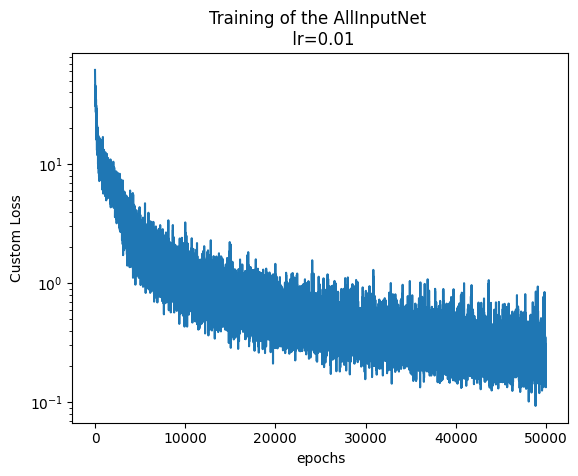

In [10]:
plt.plot(L.sum(axis=1))
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.01')
plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')

## calculating myus

In [11]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)
net.loaddata_precalculate(state)


Processed up to index 819200: 100%|██████████| 200/200 [00:40<00:00,  4.89it/s]


100%|██████████| 100/100 [00:02<00:00, 45.48it/s]


tensor([[62.5008, 62.1132, 62.6074, 62.6781],
        [62.2359, 62.4266, 62.0522, 62.5300],
        [62.6158, 62.8309, 62.5233, 60.7014],
        [60.6706, 62.5730, 61.5505, 63.2376]], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


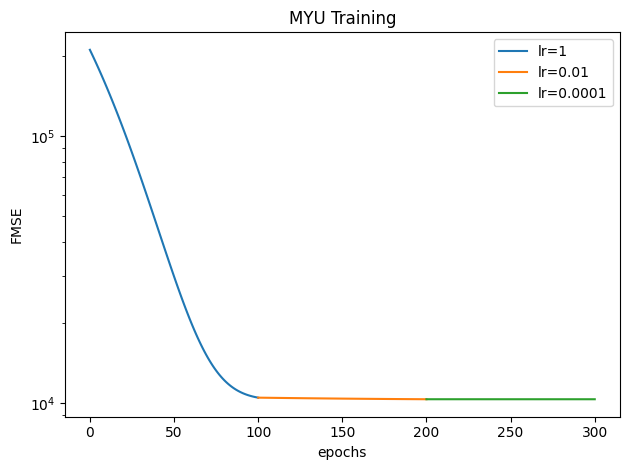

In [12]:
i = 0
for lr in [1,0.01,0.0001]:
    L = net.myutrain(lr=lr, epochs=100)    
    l = net.fmse().cpu().detach().numpy()
    L += [l]
    net.myuloss.clear()
 
    plt.plot(range(i,i+len(L)), L, label=f'lr={lr}')
    i+=len(L)-1
    
print(net.myuparam[-1])

plt.yscale('log')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('FMSE')
plt.title('MYU Training')
plt.tight_layout()
plt.savefig(f'{mtlibpath_prefix}_myutraining.png')
plt.show()

## Training with fmse

In [13]:
net.save_model(model_filepath)

Model saved to ../models/main-simulation-2-N-64-L-10-Myu-4.pt


In [14]:
np.random.seed(0)
torch.manual_seed(0)

net.load_model(model_filepath)

net.myuoptimizer.param_groups[0]['lr'] = 1e-3
net.optimizer.param_groups[0]['lr'] = 1e-4

epochs = 300
batch_size = 64
verbose = 2

L = []
for s in state.generate_batches(nbatches = epochs, batch_size = batch_size, verbose = verbose):
    s.myu = net.myu.flatten()[s.slice]
    net.optimizer.zero_grad()
    net.myuoptimizer.zero_grad()
    y = s.get_2d_tensor_state().T
    f, y_pred = MYULOSS.net_f(net,s)
    MS, RI = net.msef(
            y_pred if is_simulation else ALLINPUTNET.y_proc(y_pred)
        ,y)
    FMSE = torch.mean(torch.abs(f) ** 2) / torch.sum(y_pred**2)
    L.append(
        (MS.cpu().detach().numpy(),
        RI.cpu().detach().numpy(),
        FMSE.cpu().detach().numpy())
        )
    (FMSE + MS + RI).backward(retain_graph=True)
    net.optimizer.step()
    net.myuoptimizer.step()
    free_memory(FMSE, MS, RI, f, y_pred)

L = np.array(L)

Model loaded from ../models/main-simulation-2-N-64-L-10-Myu-4.pt


100%|██████████| 300/300 [00:06<00:00, 44.51it/s]


tensor([[62.5008, 62.1132, 62.6074, 62.6781],
        [62.2359, 62.4266, 62.0522, 62.5300],
        [62.6158, 62.8309, 62.5233, 60.7014],
        [60.6706, 62.5730, 61.5505, 63.2376]], dtype=torch.float64,
       grad_fn=<SelectBackward0>)


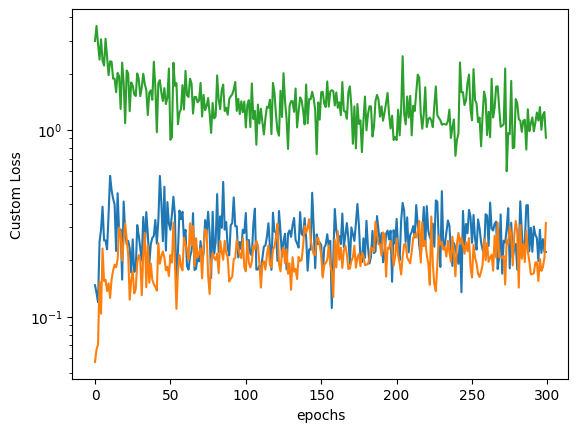

In [15]:
print(net.myuparam[-1])
plt.plot(L)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')

## Visualizing and saving plot gifs

In [16]:
def process_frame(index, u_im_real, o_im_real, phase,  title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Display the u_pred image
    im1 = axs[0].imshow(u_im_real[index])
    axs[0].set_title(title + " (u_pred) without normalization" + f" - Frame: {index}")
    axs[0].title.set_position([.5, 1.05])
    
    # Display the original image
    im2 = axs[1].imshow(o_im_real[index])
    axs[1].set_title(title + " (original) without normalization" + f" - Frame: {index}")
    axs[1].title.set_position([.5, 1.05])
    
    # Display the difference image
    im3 = axs[2].imshow(np.abs(u_im_real[index] - o_im_real[index]))
    axs[2].set_title(title + " (difference) without normalization" + f" - Frame: {index}")
    axs[2].title.set_position([.5, 1.05])
    
    # Add colorbars
    fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
    fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
    
    # Draw the figure and store the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)
    
    return image

In [17]:
def process_subframe(fig, ax, m, title):
    
    im = ax.imshow(m)
    ax.title.set_position([.5, 1.05])
    im = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    
def process_frame(M, titles):
    figsize = (M.shape[0], M.shape[1])
    fig, axs = plt.subplots(*figsize, figsize=(18, 6))
    
    # Draw
    for i in range(figsize[0]):
        for j in range(figsize[1]):
            ax = axs[i][j]
            process_subframe(fig,axs[i][j], M[i][j],titles[i][j])
            
    # Draw the figure and store the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)
    
    return image   

def create_video(M,titles, videotitle, save=True, fps=30):
    
    
    num_cores = multiprocessing.cpu_count()
#    images = Parallel(n_jobs=num_cores)(delayed(process_frame)((m,titles) for m in tqdm(M)))
    images = [process_frame(m,titles) for m in M]
    if save:
        images_to_video(images, videotitle, fps=30)
        print("Video successfully saved at", videotitle)
    
    return None

def create_video(M,titles, videotitle, save=True, fps=30):
    
    
    images = [process_frame(m,titles) for m in M]
    #Parallel(n_jobs=num_cores)(delayed(process_frame)(m, titles) for m in tqdm(M))
    if save:
        # Convert images to 8-bit color for video
        images = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in images]
        height, width, _ = images[0].shape
        video = cv2.VideoWriter(videotitle, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
        for img in images:
            video.write(img)
        video.release()
        print("Video successfully saved at", videotitle)
    
    return None

In [18]:
from __future__ import annotations
import cv2
import torch
import imageio
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Optional
from joblib import Parallel, delayed
from torch.nn.parameter import Parameter
from IPython.display import display, Image



In [19]:
module_sq = lambda a: np.real(a)**2 + np.imag(a)**2
phase = lambda a: np.arcsin(np.real(a)/np.sqrt(np.real(a)**2+np.imag(a)**2))
real_imag = lambda a: np.real(a)*np.imag(a)
real = lambda a: np.real(a)
imag = lambda a: np.imag(a)

funlist_name = ["module_sq", "phase","real_imag","real","imag"]
funlist = [module_sq, phase, real_imag, real, imag]

myu = myu_original[0]
myupred = net.myu.cpu().detach().numpy()

A_pred = net.predict(state.flatten().get_2d_tensor_xyt().T).reshape(A_original[0].shape)

In [20]:
ATenzor = np.array([np.stack([
                    np.stack([fun(A) for fun in funlist]),
                    np.stack([fun(Ap) for fun in funlist])
                    ]) for A, Ap in zip(A_original[0], A_pred)])
                    

In [21]:
MTenzor = np.array([np.array([m,mp]) for m, mp in zip(myu,myupred)])

In [22]:
AMTenzor = np.concatenate((MTenzor[:, :, np.newaxis, :, :], ATenzor), axis=2)

In [23]:
create_video(AMTenzor, titles=[['myu'] + funlist_name]*2, videotitle = path+'.mp4')

Video successfully saved at main-simulation-2-N-64-L-10-Myu-4.mp4


In [24]:
1+1

2